In [1]:
import numpy as np
import sys
sys.path.append("/users/tom/git/neon_blink_detection/")

from training.video_loader import video_loader
from src.helper import OfParams
from pathlib import Path
from src.neon_blink_detector import detect_blinks
import typing as T
from helper import OfParams, PPParams, AugParams
from post_processing import post_process
from xgboost import XGBClassifier
from pathlib import Path
import joblib
from features_calculator import calculate_optical_flow, concatenate_features, create_grids
from utils import resize_images, rotate_images

video_path = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()

iclip = 4

clip_names = [
    "2023-03-01_09-59-07-2ea49126",  # kai bike
    "2023-01-27_15-59-54-49a115d5",  # tom computer
    "2023-02-01_11-45-11-7621531e",  # kai computer
    "2023-01-27_16-10-14-a2a8cbe1",  # ryan discussing
    "2023-01-27_16-15-26-57802f75",  # tom walking
    "2023-01-27_16-24-04-eb4305b1",  # kai walking
    "2023-01-27_16-31-52-5f743ed0",  # moritz snowboarding
    "padel_tennis_neon_01-b922b245",  # mgg padel
    "padel_tennis_neon_03-2ded8f56",  # mgg partner padel
]


def get_params() -> T.Tuple[OfParams, PPParams]:
    """Get optical flow parameters and post processing parameters."""

    of_params = OfParams(5, 7, False, (64, 64), 4, 7, 15, 3)
    pp_params = PPParams(
        max_gap_duration_s=0.03,
        short_event_min_len_s=0.1,
        smooth_window=11,
        proba_onset_threshold=0.25,
        proba_offset_threshold=0.25,
    )
    
    aug_params = AugParams()
    return of_params, pp_params

def get_classifier(clf_path: Path) -> XGBClassifier:
    """Get classifier with weights."""

    return joblib.load(str(clf_path))

of_params, pp_params = get_params()
aug_params = AugParams()
of_params.n_layers = 5
of_params.layer_interval = 7
of_params.grid_size = 4
of_params.window_size = 15

clf = get_classifier("/users/tom/git/neon_blink_detection/weights/xgb.sav")

rec = video_loader(of_params, aug_params)
ts, images_left, images_right = rec._get_frames_pyav(clip_names[iclip], convert_to_gray=True)

times = (ts - ts[0]) / 1e9
# times = np.arange(0, len(ts)) / 200.0
blink_df = rec._load_gt_labels(clip_names[iclip])

grid = create_grids(of_params.img_shape, of_params.grid_size+2, full_grid=False)
images_left, images_right = resize_images(images_left, images_right, of_params.img_shape)

feature_array, _ = calculate_optical_flow(of_params, images_left, images_right, grids=grid)

features = concatenate_features(feature_array, of_params)
proba = clf.predict_proba(features)
blink_events = post_process(ts, proba, pp_params)

from src.utils import resize_images

left_images, right_images = resize_images(
    images_left, images_right, img_shape=(64, 64)
)

blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
blink_off_idx = np.where(np.isin(ts, blink_ts))[0]


img_left = np.concatenate([left_images[blink_on_idx[x]: blink_off_idx[x], :, :] for x in range(len(blink_on_idx))])
img_right = np.concatenate([right_images[blink_on_idx[x]: blink_off_idx[x], :, :] for x in range(len(blink_on_idx))])

predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])

predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

def compute_iou(event1, event2):
    start1, end1 = event1
    start2, end2 = event2
    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)
    intersection_length = max(0, intersection_end - intersection_start)
    
    union_start = min(start1, start2)
    union_end = max(end1, end2)
    union_length = union_end - union_start

    return intersection_length / union_length

def compute_multiple_iou(ground_truth_events, predicted_events, iou_threshold=0.2):
    ground_truth_indices = set(range(len(ground_truth_events)))
    predicted_indices = set(range(len(predicted_events)))
    iou_results = []
    true_positives = []

    for gt_index, gt_event in enumerate(ground_truth_events):
        for pred_index, pred_event in enumerate(predicted_events):
            iou = compute_iou(gt_event, pred_event)
            if iou > iou_threshold:
                iou_results.append((gt_index, pred_index, iou))
                true_positives.append((pred_index, predicted_events[pred_index]))
                if gt_index in ground_truth_indices:
                    ground_truth_indices.remove(gt_index)
                if pred_index in predicted_indices:
                    predicted_indices.remove(pred_index)

    false_negatives = [(i, ground_truth_events[i]) for i in ground_truth_indices]
    false_positives = [(i, predicted_events[i]) for i in predicted_indices]

    return iou_results, true_positives, false_negatives, false_positives


pred = [(predicted_blink_on[x], predicted_blink_off[x]) for x in range(len(predicted_blink_on))]

gt = [(blink_on_idx[x], blink_off_idx[x]) for x in range(len(blink_on_idx))]

iou_results, true_positives, false_negatives, false_positives = compute_multiple_iou(gt, pred, iou_threshold=0.2)



/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


**CREATE VIDEO OF FALSE POSITIVES**

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML


for i in range(len(false_positives)):

    fig, axs = plt.subplots(2, 2)

    video_left = images_left[false_positives[i][1][0]:false_positives[i][1][1],:,:]
    video_right = images_right[false_positives[i][1][0]:false_positives[i][1][1],:,:]

    fig.set_size_inches(8, 6)
    im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
    im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
    axs[0, 0].axis("off")
    axs[0, 1].axis("off")

    plt.close() # this is required to not display the generated image

    # plot proba output of the classifier for the false positive event
    axs[1, 0].plot(proba[false_positives[i][1][0]:false_positives[i][1][1], :])
    axs[1, 0].set_xlabel("Frame")
    axs[1, 0].set_ylabel("Probability")
    # legend
    axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")

    axs[1, 1].axis("off")

    def init():
        im0.set_data(video_left[0,:,:])
        im1.set_data(video_right[0,:,:])

    def animate(frame):
        im0.set_data(video_left[frame,:,:])
        im1.set_data(video_right[frame,:,:])

        return im0, im1

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

    anim.save('/users/tom/blink_videos/FP%d_rec%s.mp4' %(i, clip_names[iclip]), extra_args=['-vcodec', 'libx264'])

    HTML(anim.to_html5_video())

**CREATE VIDEO OF FALSE NEGTIVES**

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML


for i in range(len(false_negatives)):

    fig, axs = plt.subplots(2, 2)

    video_left = images_left[false_negatives[i][1][0]:false_negatives[i][1][1],:,:]
    video_right = images_right[false_negatives[i][1][0]:false_negatives[i][1][1],:,:]

    fig.set_size_inches(8, 6)
    im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
    im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
    axs[0, 0].axis("off")
    axs[0, 1].axis("off")

    plt.close() # this is required to not display the generated image

    # plot proba output of the classifier for the false positive event
    axs[1, 0].plot(proba[false_negatives[i][1][0]:false_negatives[i][1][1], :])
    axs[1, 0].set_xlabel("Frame")
    axs[1, 0].set_ylabel("Probability")
    # legend
    axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")

    axs[1, 1].axis("off")

    def init():
        im0.set_data(video_left[0,:,:])
        im1.set_data(video_right[0,:,:])

    def animate(frame):
        im0.set_data(video_left[frame,:,:])
        im1.set_data(video_right[frame,:,:])

        return im0, im1

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

    anim.save('/users/tom/blink_videos/FN%d_rec%s.mp4' %(i, clip_names[iclip]), extra_args=['-vcodec', 'libx264'])

    HTML(anim.to_html5_video())

**VIDEOS OF TRUE POSITIVES**

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML


for i in range(len(true_positives)):

    fig, axs = plt.subplots(2, 2)

    video_left = images_left[true_positives[i][1][0]:true_positives[i][1][1],:,:]
    video_right = images_right[true_positives[i][1][0]:true_positives[i][1][1],:,:]

    fig.set_size_inches(8, 6)
    im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
    im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
    axs[0, 0].axis("off")
    axs[0, 1].axis("off")

    plt.close() # this is required to not display the generated image

    # plot proba output of the classifier for the false positive event
    axs[1, 0].plot(proba[true_positives[i][1][0]:true_positives[i][1][1], :])
    axs[1, 0].set_xlabel("Frame")
    axs[1, 0].set_ylabel("Probability")
    # legend
    axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")

    axs[1, 1].axis("off")

    def init():
        im0.set_data(video_left[0,:,:])
        im1.set_data(video_right[0,:,:])

    def animate(frame):
        im0.set_data(video_left[frame,:,:])
        im1.set_data(video_right[frame,:,:])

        return im0, im1

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

    anim.save('/users/tom/blink_videos/TP%d_rec%s.mp4' %(i, clip_names[iclip]), extra_args=['-vcodec', 'libx264'])

    HTML(anim.to_html5_video())

**PLOT GROUND TRUTH AND PREDICTED BLINKS**

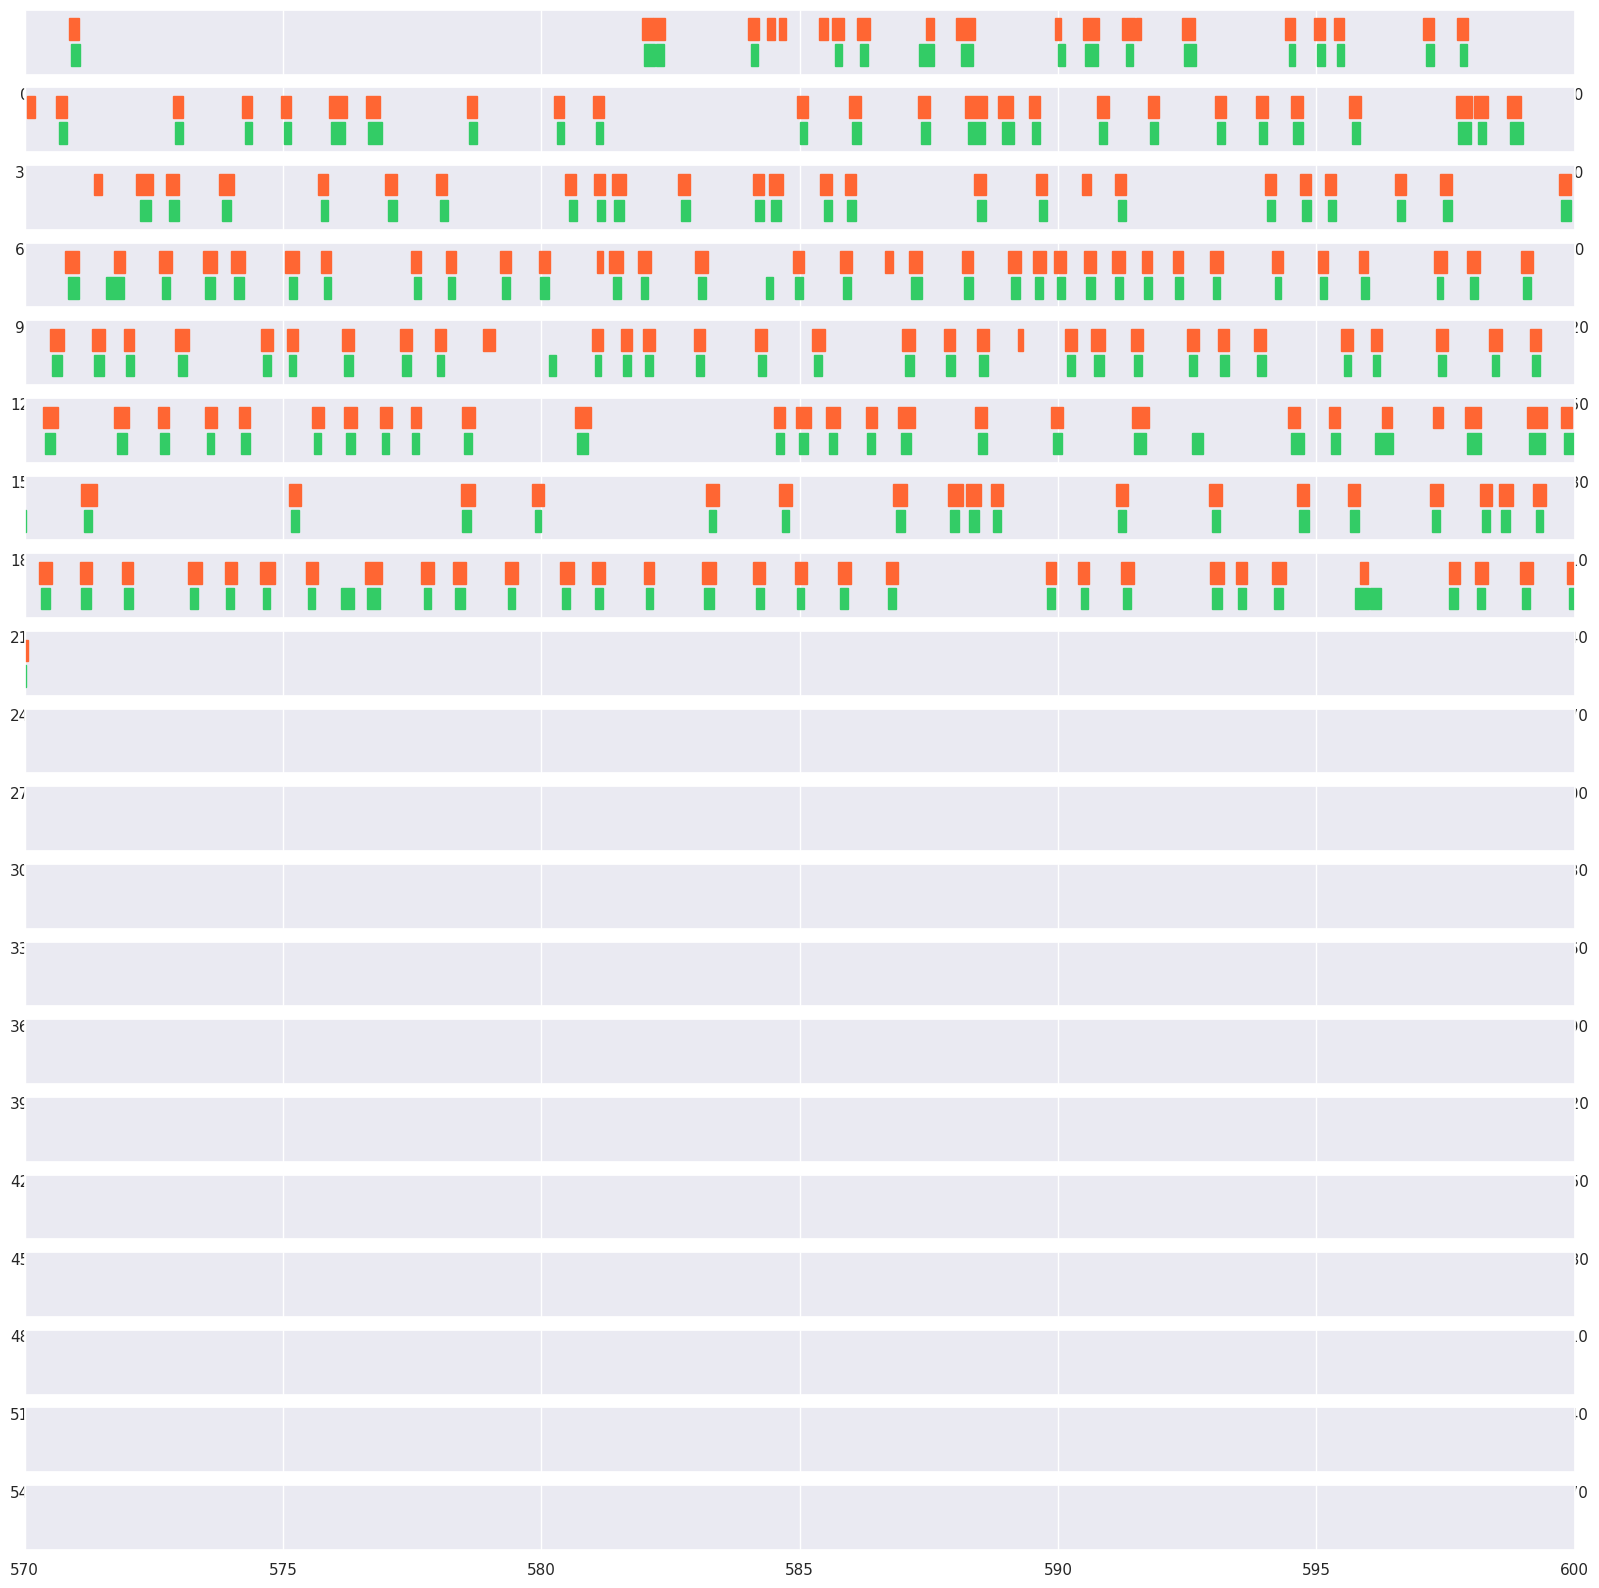

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib.patches import Rectangle

def render_event_array(ax, blink_on_idx, blink_off_idx, y, color):
    # flags = np.ones(len(legend_labels))
    legends = {}

    for i in range(len(blink_on_idx)):
        start = blink_on_idx[i]/200
        end = blink_off_idx[i]/200
        height = 0.5
        patch = Rectangle((start, y), end - start, height, color=color)
        ax.add_patch(patch)
        # legends["blink"] = patch

    ax.set_yticks([])
    ax.set_ylim(0, 1.5)

def create_subplot(ax, on_idx, off_idx, pred_on, pred_off, start, end, colors):
    render_event_array(ax, on_idx, off_idx, 0.2, color=colors[0])
    render_event_array(ax, pred_on, pred_off, 0.8, color=colors[1])
    ax.set_xlim(start, end)


blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
blink_off_idx = np.where(np.isin(ts, blink_ts))[0]

predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])
predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

f, ax = plt.subplots(20, 1)
f.set_size_inches(20, 20)

colors = [[0.2, 0.8, 0.4], [1, 0.4, 0.2]]
time_intervals = [(i * 30, (i + 1) * 30) for i in range(20)]

for i, (start, end) in enumerate(time_intervals):
    create_subplot(ax[i], blink_on_idx, blink_off_idx, predicted_blink_on, predicted_blink_off, start, end, colors)


In [20]:
from label_mapper import label_mapping
from src.utils import resize_images
from src.post_processing import smooth_array, smooth_proba, classify


# Load each blink event
def get_confidence(start_idx, end_idx, smoothed_proba):
    """ Compute confidence for a blink event

    Parameters
    ----------
    start_idx : int
        Index of the start of the blink event
    end_idx : int
        Index of the end of the blink event
    proba : array
        Array of shape (n_samples, n_classes) containing the output of the classifier
    pp_params : dict
        Dictionary containing the parameters of the post-processing

    Returns
    -------
    confidence_blink : float
        Confidence of the classifier for the blink event
    confidence_onset : float
        Confidence of the classifier for the onset of the blink event
    confidence_offset : float
        Confidence of the classifier for the offset of the blink event
    """

    tmp_proba = smoothed_proba[start_idx:end_idx, :]

    transition_on_off = np.where(tmp_proba[:,2] >= tmp_proba[:,1])[0][0]
   
    confidence_onset = np.mean(tmp_proba[:transition_on_off, 1])
    confidence_offset = np.mean(tmp_proba[transition_on_off:, 2])
    confidence_blink = (confidence_onset + confidence_offset)/2

    return confidence_blink, confidence_onset, confidence_offset

def find_ts_index(ts, t):
    """ Find index of a timestamp in a list of timestamps

    Parameters
    ----------
    ts : array
        Array of timestamps
    t : float
        Timestamp to find

    Returns
    -------
    idx : int
        Index of the timestamp in the array
    """
    
    return np.where(ts == t)[0][0]

def get_blink_events(clip_name, clf):
    """ Load a recording and return the timestamps, images and blink events

    Parameters
    ----------
    iclip : int
        Index of the recording to load

    Returns
    -------
    ts : array
        Array of timestamps
    images_left : array
        Array of shape (n_samples, height, width, 1) containing the left images
    images_right : array
        Array of shape (n_samples, height, width, 1) containing the right images
    blink_events : list
        List of blink events
    """

    of_params, pp_params = get_params()
    aug_params = AugParams()
    of_params.n_layers = 5
    of_params.layer_interval = 7
    of_params.grid_size = 4
    of_params.window_size = 15

    rec = video_loader(of_params, aug_params)
    ts, images_left, images_right = rec._get_frames_pyav(clip_name, 
    convert_to_gray=True)

    t = rec._get_timestamps(clip_name)
    times = (ts - t[0]) / 1e9

    blink_df = rec._load_gt_labels(clip_name)

    grid = create_grids(of_params.img_shape, of_params.grid_size+2, full_grid=False)
    images_left, images_right = resize_images(images_left, images_right, of_params.img_shape)

    feature_array, _ = calculate_optical_flow(of_params, images_left, images_right, grids=grid)

    features = concatenate_features(feature_array, of_params)
    proba = clf.predict_proba(features)
    blink_events = post_process(ts, proba, pp_params)


    left_images, right_images = resize_images(
        images_left, images_right, img_shape=(64, 64)
    )

    blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
    blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
    blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
    blink_off_idx = np.where(np.isin(ts, blink_ts))[0]
    
    predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])

    predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

    pred = [(predicted_blink_on[x], predicted_blink_off[x]) for x in range(len(predicted_blink_on))]

    gt = [(blink_on_idx[x], blink_off_idx[x]) for x in range(len(blink_on_idx))]

    return pred, gt, proba, left_images, right_images, times



In [160]:
data_dict = {}

clf = get_classifier("/users/tom/git/neon_blink_detection/weights/xgb.sav")

for clip_name in clip_names:
    print("Processing clip %s" %(clip_name))

    clip_data = {
        'confidence_probas_tp': [],
        'confidence_li_tp': [],
        'confidence_ri_tp': [],
        'confidence_blink_tp': [],

        'confidence_probas_fp': [],
        'confidence_li_fp': [],
        'confidence_ri_fp': [],
        'confidence_blink_fp': [],

        'true_positives': [],
        'false_positives': [],
    }

    pred_blink, gt_blinks, proba, li, ri, times = get_blink_events(clip_name, clf)
    smoothed_proba = smooth_proba(proba, pp_params)
    iou_results, true_positives, false_negatives, false_positives = compute_multiple_iou(gt_blinks, pred_blink)

    clip_data['true_positives'] = [(true_positives[x][0], tuple(times[np.array(true_positives[x][1])])) for x in range(len(true_positives))]

    clip_data['false_positives'] = [(false_positives[x][0], tuple(times[np.array(false_positives[x][1])])) for x in range(len(false_positives))]

    print("Number of false positives: {}".format(len(false_positives)))

    for i in range(len(true_positives)):
        start_idx = true_positives[i][1][0]
        end_idx = true_positives[i][1][1]
        confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = get_confidence(start_idx, end_idx, smoothed_proba)
        clip_data['confidence_blink_tp'].append(confidence_blink_tmp)
        clip_data['confidence_probas_tp'].append(smoothed_proba[start_idx:end_idx, :])  
        clip_data['confidence_li_tp'].append(li[start_idx:end_idx, :, :])
        clip_data['confidence_ri_tp'].append(ri[start_idx:end_idx, :, :])

    for i in range(len(false_positives)):
        start_idx = false_positives[i][1][0]
        end_idx = false_positives[i][1][1]
        confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = get_confidence(start_idx, end_idx, smoothed_proba)
        clip_data['confidence_blink_fp'].append(confidence_blink_tmp)
        clip_data['confidence_probas_fp'].append(smoothed_proba[start_idx:end_idx, :])
        clip_data['confidence_li_fp'].append(li[start_idx:end_idx, :, :])
        clip_data['confidence_ri_fp'].append(ri[start_idx:end_idx, :, :])

    data_dict[clip_name] = clip_data

Processing clip 0
Number of false positives: 12
Processing clip 1


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 3
Processing clip 2


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 21
Processing clip 3
Number of false positives: 2
Processing clip 4
Number of false positives: 4
Processing clip 5


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 8
Processing clip 6


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 0
Processing clip 7


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 7
Processing clip 8


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 2


In [43]:
(np.array(gt) / 200)[1 ,:]

array([5.715, 5.905])

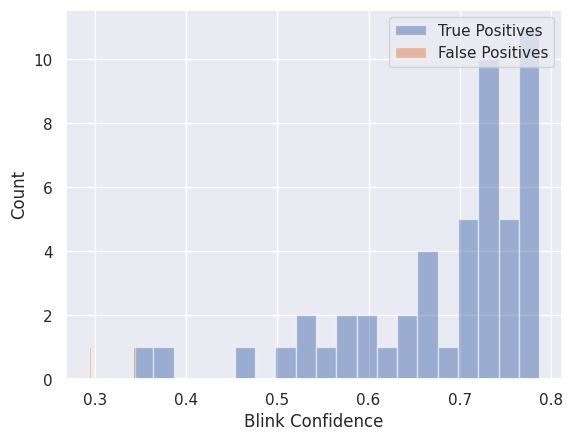

In [31]:
import matplotlib.pyplot as plt
# same as above, but normalize the two histograms to the same area
fig, ax = plt.subplots(1, 1)
ax.hist(clip_data['confidence_blink_tp'], bins=20, alpha=0.5, label="True Positives", density=False)
ax.hist(clip_data['confidence_blink_fp'], bins=20, alpha=0.5, label="False Positives", density=False)
ax.set_xlabel("Blink Confidence")
ax.set_ylabel("Count")
ax.legend(loc="upper right")
# ax.set_ylim(0, 10)

**CREATE VIDEO SHOWING CONFIDENCE AND PROBABILITIES**

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns
iclip = 5

confidence_blink = np.array(data_dict[clip_names[iclip]]['confidence_blink_tp'])
confidence_blink_sorted_idx = np.argsort(confidence_blink)

index = confidence_blink_sorted_idx[0]
print(index)

fig, axs = plt.subplots(2, 2)

video_left = data_dict[clip_names[iclip]]["confidence_li_tp"][index]
video_right = data_dict[clip_names[iclip]]["confidence_ri_tp"][index]

fig.set_size_inches(8, 6)
im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
axs[0, 0].axis("off")
axs[0, 1].axis("off")

plt.close() # this is required to not display the generated image

# plot proba output of the classifier for the false positive event
axs[1, 0].plot(data_dict[clip_names[iclip]]['confidence_probas_tp'][index])
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlabel("Frame")
axs[1, 0].set_ylabel("Probability")
# legend
axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")
sns.set()

# Create a vertical line object
vline = axs[1, 0].axvline(x=0, color=[0.5, 0.5, 0.5], linestyle=':')

axs[1, 1].text(0.5, 0.5, "Blink Confidence: %.2f" %(confidence_blink[index]), fontsize=14, ha='center')
axs[1, 1].text(0.5, 0.3, "Start: %.2f" %(data_dict[clip_names[iclip]]['true_positives'][index][0]), fontsize=12, ha='center')
# add clip name
axs[1, 1].text(0.5, 0.2, "Clip: %s" %(clip_names[iclip]), fontsize=12, ha='center')

axs[1, 1].axis("off")

def init():
    im0.set_data(video_left[0,:,:])
    im1.set_data(video_right[0,:,:])
    vline.set_xdata(0)

def animate(frame):
    im0.set_data(video_left[frame,:,:])
    im1.set_data(video_right[frame,:,:])
    vline.set_xdata(frame) # Update the vertical line position

    return im0, im1, vline

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

anim.save('/users/tom/blink_videos/false_positive_example_%.2f.mp4' %(confidence_blink[index]), extra_args=['-vcodec', 'libx264'])

HTML(anim.to_html5_video())


130


/tmp/ipykernel_1890375/3379065982.py:49: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  vline.set_xdata(0)
/tmp/ipykernel_1890375/3379065982.py:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  vline.set_xdata(frame) # Update the vertical line position
/tmp/ipykernel_1890375/3379065982.py:49: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  vline.set_xdata(0)
/tmp/ipykernel_1890375/3379065982.py:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  vline.set_xdata(frame) # Update the vertical line position


<font size = 5> Compute false positives and true positives for training & validation data

**get_blink_events needs to be slightly adjusted**

In [22]:


import timeit


def get_blink_events(clip_name, clf, proba):
    """ Load a recording and return the timestamps, images and blink events

    Parameters
    ----------
    iclip : int
        Index of the recording to load

    Returns
    -------
    ts : array
        Array of timestamps
    images_left : array
        Array of shape (n_samples, height, width, 1) containing the left images
    images_right : array
        Array of shape (n_samples, height, width, 1) containing the right images
    blink_events : list
        List of blink events
    """

    of_params, pp_params = get_params()
    aug_params = AugParams()
    of_params.n_layers = 5
    of_params.layer_interval = 7
    of_params.grid_size = 4
    of_params.window_size = 15

    rec = video_loader(of_params, aug_params)
    ts, images_left, images_right = rec._get_frames_pyav(clip_name, 
    convert_to_gray=True)



    blink_df = rec._load_gt_labels(clip_name)
    blink_events = post_process(ts, proba, pp_params)


    left_images, right_images = resize_images(
        images_left, images_right, img_shape=(64, 64)
    )

    blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
    blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
    blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
    blink_off_idx = np.where(np.isin(ts, blink_ts))[0]
    
    predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])

    predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

    pred = [(predicted_blink_on[x], predicted_blink_off[x]) for x in range(len(predicted_blink_on))]

    gt = [(blink_on_idx[x], blink_off_idx[x]) for x in range(len(blink_on_idx))]

    return pred, gt, proba, left_images, right_images

**Load classifier weights and class probabilities**

In [24]:

import pickle
from training.dataset_splitter import load_dataset_splitter

true_positive_confidence = []
false_positive_confidence = []


dataset_splitter = load_dataset_splitter(n_clips=None, n_splits=5)
for idx, (_, clip_tuples_val) in enumerate(dataset_splitter):

    if idx==0:
        continue

    fn = "/users/tom/git/neon_blink_detection/export-XGBClassifier-3-100320231148/n_lay5-lay_intv7-grid4-win15-trans0.0-scale0.0/samples-%d.pkl" %idx

    with open(fn, 'rb') as f:
        data = pickle.load(f)

    clf = "/users/tom/git/neon_blink_detection/export-XGBClassifier-3-100320231148/n_lay5-lay_intv7-grid4-win15-trans0.0-scale0.0/weights-%d.sav" %idx

    all_probas = np.load("/users/tom/git/neon_blink_detection/export-XGBClassifier-3-100320231148/n_lay5-lay_intv7-grid4-win15-trans0.0-scale0.0/proba-%d.npy" %idx, allow_pickle=True)

    for clip_name in clip_tuples_val[0:2]:
        print("Processing clip %s" %(clip_name))

    try:

        pred_blink, gt_blinks, proba, li, ri = get_blink_events(clip_name, clf, all_probas[clip_name])
        smoothed_proba = smooth_proba(all_probas[clip_name], pp_params)
        iou_results, true_positives, false_negatives, false_positives = compute_multiple_iou(gt_blinks, pred_blink)

        print("Number of false positives: {}".format(len(false_positives)))

        for i in range(len(true_positives)):
            start_idx = true_positives[i][1][0]
            end_idx = true_positives[i][1][1]
            confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = get_confidence(start_idx, end_idx, smoothed_proba)
            true_positive_confidence.append(confidence_blink_tmp)

        for i in range(len(false_positives)):
            start_idx = false_positives[i][1][0]
            end_idx = false_positives[i][1][1]
            confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = get_confidence(start_idx, end_idx, smoothed_proba)
            false_positive_confidence.append(confidence_blink_tmp)

        recall = len(true_positives) / (len(true_positives) + len(false_negatives))
        precision = len(true_positives) / (len(true_positives) + len(false_positives))
        f1 = 2 * (precision * recall) / (precision + recall)

        print("Recall: {}".format(recall))
        print("Precision: {}".format(precision))
        print("F1: {}".format(f1))

    except:
        print("Error processing clip %s" %(clip_name))

np.save("true_positive_confidence.npy", np.array(true_positive_confidence))
np.save("false_positive_confidence.npy", np.array(false_positive_confidence))

72 training clips & 17 validation clips.
Processing clip 1000-2022-12-14-09-43-56-0fcac6d3
Processing clip 1002-2022-12-14-11-43-58-23e05b8c
Number of false positives: 1
Recall: 0.7142857142857143
Precision: 0.9090909090909091
F1: 0.8
Processing clip 1202-2023-01-19-13-17-50-3651315a
Processing clip 1219-2023-01-23-10-52-53-f0f1506f
Number of false positives: 8
Recall: 0.8743169398907104
Precision: 0.9523809523809523
F1: 0.9116809116809117
Processing clip 1266-2023-01-27-10-32-47-144fd890
Processing clip 1267-2023-01-27-11-38-27-264bce1d
Number of false positives: 1
Recall: 1.0
Precision: 0.9722222222222222
F1: 0.9859154929577464
Processing clip 1248-2023-01-25-12-59-30-e6407072
Processing clip 1249-2023-01-25-14-29-18-e54693e4
Number of false positives: 4
Recall: 1.0
Precision: 0.8095238095238095
F1: 0.8947368421052632
Processing clip 1311-2023-02-02-14-30-40-96be0928
Processing clip 1312-2023-02-02-16-21-47-cd28e8e0
Number of false positives: 0
Recall: 0.9411764705882353
Precision: 1

array([0.75107408, 0.76037198, 0.70781183, 0.58523583, 0.51663315,
       0.77587318, 0.72421378, 0.60435784, 0.68236339, 0.77178502,
       0.63768268, 0.55584311, 0.59243357, 0.44492376, 0.47121462,
       0.53041255, 0.63075584, 0.4230454 , 0.45378959, 0.63543057,
       0.4951438 , 0.65990698, 0.44285816, 0.4113518 , 0.72511643,
       0.69053906, 0.48808655, 0.59476483, 0.60229766, 0.70162266,
       0.59781253, 0.48659635, 0.61267185, 0.69377309, 0.71907461,
       0.68897277, 0.66022927, 0.58845347, 0.52102113, 0.67326844,
       0.42139342, 0.48726827, 0.70890331, 0.39205319, 0.69482172,
       0.74711204, 0.62613761, 0.58227223, 0.76166052, 0.65178645,
       0.68629086, 0.67519951, 0.71882719, 0.66203225, 0.67198837,
       0.63419592, 0.66671479, 0.44752789, 0.71382707, 0.70523632,
       0.50437415, 0.68243575, 0.64113891, 0.3616122 , 0.48493791,
       0.55048501, 0.63576436, 0.58748853, 0.51988745, 0.6871779 ,
       0.63055432, 0.51276505, 0.67955488, 0.6411097 , 0.67762

-2

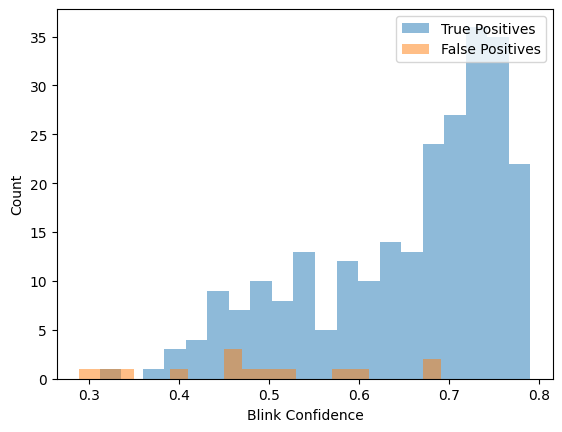

In [25]:
import matplotlib.pyplot as plt
# same as above, but normalize the two histograms to the same area
fig, ax = plt.subplots(1, 1)
ax.hist(true_positive_confidence, bins=20, alpha=0.5, label="True Positives", density=False)
ax.hist(false_positive_confidence[0:100], bins=20, alpha=0.5, label="False Positives", density=False)
ax.set_xlabel("Blink Confidence")
ax.set_ylabel("Count")
ax.legend(loc="upper right")
# ax.set_ylim(0, 10)

In [170]:
all_probas["1202-2023-01-19-13-17-50-3651315a"]

array([[0.99602675, 0.00249168, 0.00148162],
       [0.9960311 , 0.00237173, 0.0015972 ],
       [0.99592555, 0.00247748, 0.00159703],
       ...,
       [0.96533215, 0.03252341, 0.00214449],
       [0.9656064 , 0.03158013, 0.00281351],
       [0.96849203, 0.02857786, 0.00293019]], dtype=float32)

In [174]:
# rec = video_loader(of_params, aug_params)
# ts, images_left, images_right = rec._get_frames_pyav(clip_names_val[0], 
# convert_to_gray=True)

# t = rec._get_timestamps(clip_names_val[0])
# times = (ts - t[0]) / 1e9

# blink_df = rec._load_gt_labels(clip_names_val[0])

# proba = all_probas[clip_names_val[0]]

# # grid = create_grids(of_params.img_shape, of_params.grid_size+2, full_grid=False)
# # images_left, images_right = resize_images(images_left, images_right, of_params.img_shape)

# # feature_array, _ = calculate_optical_flow(of_params, images_left, images_right, grids=grid)

# # features = concatenate_features(feature_array, of_params)
# # proba = clf.predict_proba(features)
# blink_events = post_process(ts, proba, pp_params)



blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
blink_off_idx = np.where(np.isin(ts, blink_ts))[0]

predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])

predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

pred = [(predicted_blink_on[x], predicted_blink_off[x]) for x in range(len(predicted_blink_on))]

gt = [(blink_on_idx[x], blink_off_idx[x]) for x in range(len(blink_on_idx))]

IndexError: index 80 is out of bounds for axis 0 with size 80

In [177]:
gt = [(blink_on_idx[x], blink_off_idx[x]) for x in range(len(blink_on_idx))]

range(0, 81)

In [182]:
[(blink_off_idx[x]) for x in range(len(blink_on_idx))]

IndexError: index 80 is out of bounds for axis 0 with size 80

In [183]:
len(blink_off_idx)

80

In [46]:
import pickle

fn = "/users/tom/git/neon_blink_detection/export-XGBClassifier-3-100320231148/n_lay5-lay_intv7-grid4-win15-trans0.0-scale0.0/samples-2.pkl"

with open(fn, 'rb') as f:
    data = pickle.load(f)

clip_names_val = list(data.keys())[0:-9]


In [47]:
clip_names_val[-17:]

['1202-2023-01-19-13-17-50-3651315a',
 '1219-2023-01-23-10-52-53-f0f1506f',
 '1230-2023-01-24-10-34-24-8e573035',
 '1250-2023-01-25-15-28-28-e49f5c02',
 '1253-2023-01-26-11-39-39-c0de66cb',
 '1280-2023-01-30-14-24-40-d879dc2a',
 '1293-2023-02-01-10-13-34-0c9638f8',
 '1294-2023-02-01-11-11-04-442d1d78',
 '1297-2023-02-01-13-37-41-668a3c8e',
 '1298-2023-02-01-14-29-40-08017935',
 '1299-2023-02-01-14-37-00-65f38d85',
 '1300-2023-02-01-15-30-06-808aa97c',
 '1301-2023-02-01-15-38-42-70991a8d',
 '1302-2023-02-01-16-38-55-bc30b710',
 '1303-2023-02-01-17-30-01-d3ee799c',
 '1304-2023-02-01-17-38-36-66aceb25',
 '1306-2023-02-02-10-44-25-4fec6abd']